### Imports

In [1]:
import itertools
from tqdm.auto import tqdm, trange
import random
import os
import sys
from io import StringIO
from IPython import get_ipython


import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset

from pyvene import(
    CausalModel, IntervenableModel, IntervenableConfig,
    RepresentationConfig, RotatedSpaceIntervention
)

from transformers import (
    AutoTokenizer, default_data_collator,
    DataCollatorWithPadding, get_scheduler,
    AutoModelForCausalLM, GPT2LMHeadModel
)

from accelerate import Accelerator
from accelerate.utils import set_seed

In [2]:
"""
# ipython_exit.py
Allows exit() to work if script is invoked with IPython without
raising NameError Exception. Keeps kernel alive.

Use: import variable 'exit' in target script with
     'from ipython_exit import exit'    
"""

class IpyExit(SystemExit):
    """Exit Exception for IPython.

    Exception temporarily redirects stderr to buffer.
    """
    def __init__(self):
        # print("exiting")  # optionally print some message to stdout, too
        # ... or do other stuff before exit
        sys.stderr = StringIO()

    def __del__(self):
        sys.stderr.close()
        sys.stderr = sys.__stderr__  # restore from backup


def ipy_exit():
    raise IpyExit


if get_ipython():    # ...run with IPython
    exit = ipy_exit  # rebind to custom exit
else:
    exit = exit      # just make exit importable

### Hyperparameters

In [3]:
seed = 42
mixed_precision = 'no'  # choose from no, fp16, bf16 or fp8
# needed for dataset generation in case of counterfactual dataset
batch_size = 8

set_seed(seed)

### Special variables

In [4]:
# Longest command is 9 words : https://arxiv.org/pdf/1711.00350
max_command_len = 9
# dummy tokens for formatting
EMPTY = "<empty>" # "EMPTY"
PORT = "<port>"
ACT = "<act>"

### Causal Model

In [5]:
# command type maps
actions = {
    "walk": "I_WALK",
    "run": "I_RUN",
    "jump": "I_JUMP",
    "look": "I_LOOK",
    "turn": EMPTY,
    EMPTY: EMPTY,
    }

turns = {
    "around": "yyyy",
    "opposite": "yy",
    EMPTY: EMPTY
}

directions = {
    "right": "I_TURN_RIGHT",
    "left": "I_TURN_LEFT",
    EMPTY: EMPTY
}

nums = {
    "twice": "xx",
    "thrice": "xxx",
    EMPTY: EMPTY
}

conjs = ["and", "after", EMPTY]

# command structure
command_structure = {
    0: actions,
    1: turns,
    2: directions,
    3: nums,
    4: conjs,
    5: actions,
    6: turns,
    7: directions,
    8: nums,
}


### VARIABLES ###

# longest command is 9 words : https://arxiv.org/pdf/1711.00350
# This ordering (left to right) is important for downstream code!
leaves = [
    "act1", "trn1", "dir1", "num1",
    "conj",
    "act2", "trn2", "dir2", "num2"
]
non_leaves = [
    "trn1_res", "trn1_dir1", "act1_trn1_dir1", 
    "num1_res", "act1_trn1_dir1_num1",
    "trn2_res", "trn2_dir2", "act2_trn2_dir2", 
    "num2_res", "act2_trn2_dir2_num2",
    "conj_left", "conj_right",
]
variables = leaves + non_leaves

### FUNCTIONS ###

def resolve_turn(turn):
    return turns[turn]

# need to represent ACT differently?
def turn_function(turn, dir):
    dir = directions[dir]
    if dir == EMPTY:
        return EMPTY
    elif turn == EMPTY:
        dec_act = dir + ' '+ACT+' '
    elif turn == "yyyy":
        dec_act = (dir + ' '+ACT+' ')*len(turn) 
    else:
        dec_act = (dir + ' ')*len(turn) + ACT
    return dec_act.strip()

def action_function(act, trn_dir):
    if trn_dir == EMPTY:
        return actions[act]
    return (trn_dir.replace(ACT, actions[act])).strip()

def resolve_num(num):
    return nums[num]

def num_function(act_trn_dir, num):
    if num == EMPTY:
        return act_trn_dir
    dec = (act_trn_dir + ' ') * len(num)
    return dec.strip()

def conjugation_left(act1_trn1_dir1_num1, conj):
    if conj == EMPTY:
        return act1_trn1_dir1_num1
    elif conj == "and":
        return act1_trn1_dir1_num1 + PORT
    else:
        return PORT + act1_trn1_dir1_num1
    

def conjugation_right(conj_left, act2_trn2_dir2_num2):
    if act2_trn2_dir2_num2 == EMPTY:
        f_str = conj_left
    # after
    elif conj_left.startswith(PORT):
        f_str = act2_trn2_dir2_num2 + conj_left
    # and
    else:
        f_str = conj_left + act2_trn2_dir2_num2
    f_str = f_str.replace(PORT, ' ')
    f_str = f_str.replace((' '+EMPTY+' '), ' ')
    f_str = f_str.replace(EMPTY, '')
    return f_str.strip()

functions = {

    # leaves
    "act1": lambda x: x,
    "act2": lambda x: x,
    "trn1": lambda x: x,
    "trn2": lambda x: x,
    "dir1": lambda x: x,
    "dir2": lambda x: x,
    "num1": lambda x: x,
    "num2": lambda x: x,
    "conj": lambda x: x,

    # resolving turn
    "trn1_res": resolve_turn,
    "trn2_res": resolve_turn,

    # combining turn and direction
    "trn1_dir1": turn_function,
    "trn2_dir2": turn_function,

    # combining turn_direction and action
    "act1_trn1_dir1": action_function,
    "act2_trn2_dir2": action_function,

    # resolving num
    "num1_res": resolve_num,
    "num2_res": resolve_num,

    # combining action_turn_direction and num
    "act1_trn1_dir1_num1": num_function,
    "act2_trn2_dir2_num2": num_function,

    # conj with left segment
    "conj_left": conjugation_left,

    # conj with right segment
    "conj_right": conjugation_right,
}


### VALUES ###

values = dict()

# leaves
values["act1"] = list(actions.keys())
values["act2"] = list(actions.keys())
values["trn1"] = list(turns.keys())
values["trn2"] = list(turns.keys())
values["dir1"] = list(directions.keys())
values["dir2"] = list(directions.keys())
values["num1"] = list(nums.keys())
values["num2"] = list(nums.keys())
values["conj"] = conjs


# resolve turn
values["trn1_res"] = [resolve_turn(t) for t in values["trn1"]]
values["trn2_res"] = values["trn1_res"].copy()

# turn+dir
all_trn_dir = list(itertools.product(values["trn1_res"], values["dir1"]))
values["trn1_dir1"] = list(set([turn_function(tup[0], tup[1]) for tup in all_trn_dir]))
values["trn2_dir2"] = values["trn1_dir1"].copy()

# act+turn_dir
all_act_trn_dir = list(itertools.product(values["act1"], values["trn1_dir1"]))
values["act1_trn1_dir1"] = list(set([action_function(tup[0], tup[1]) for tup in all_act_trn_dir]))
values["act2_trn2_dir2"] = values["act1_trn1_dir1"].copy()

# resolve num
values["num1_res"] = [resolve_num(n) for n in values["num1"]]
values["num2_res"] = values["num1_res"].copy()

# act_turn_dir+num
all_act_trn_dir_num = list(itertools.product(values["act1_trn1_dir1"], values["num1_res"]))
values["act1_trn1_dir1_num1"] = list(set([num_function(tup[0], tup[1]) for tup in all_act_trn_dir_num]))
values["act2_trn2_dir2_num2"] = values["act1_trn1_dir1_num1"].copy()

# conj_left
all_conj_left = list(itertools.product(values["act1_trn1_dir1_num1"], conjs))
values["conj_left"] = list(set([conjugation_left(tup[0], tup[1]) for tup in all_conj_left]))

# conj_right
all_conj_right = list(itertools.product(values["conj_left"], values["act2_trn2_dir2_num2"]))
values["conj_right"] = list(set([conjugation_right(tup[0], tup[1]) for tup in all_conj_right]))


### PARENTS ###

parents = {v:[] for v in variables}
# left subtree
parents["trn1_res"] = ["trn1"]
parents["trn1_dir1"] = ["trn1_res", "dir1"]
parents["act1_trn1_dir1"] = ["act1", "trn1_dir1"]
parents["num1_res"] = ["num1"]
parents["act1_trn1_dir1_num1"] = ["act1_trn1_dir1", "num1_res"]
# right subtree
parents["trn2_res"] = ["trn2"]
parents["trn2_dir2"] = ["trn2_res", "dir2"]
parents["act2_trn2_dir2"] = ["act2", "trn2_dir2"]
parents["num2_res"] = ["num2"]
parents["act2_trn2_dir2_num2"] = ["act2_trn2_dir2", "num2_res"]
# merge
parents["conj_left"] = ["act1_trn1_dir1_num1", "conj"]
parents["conj_right"] = ["conj_left", "act2_trn2_dir2_num2"]


### POSITIONS ###

# a dictionary with nodes as keys and positions as values
pos = {

    # left subtree
    "act1": (1, 0),
    "trn1": (2, 0),
    "dir1": (1.9, 0.05),
    "num1": (4, 0),
    "conj": (4.11, 0.1),
    "act1": (0.2, 0),
    "trn1": (1, 0.1),
    "trn1_res": (1.33, 0.4),
    "dir1": (2, 0.3),
    "num1": (2.8, 0),
    "num1_res": (3, 0.2),
    "trn1_dir1": (1.4, 0.96),
    "act1_trn1_dir1": (0.2, 1.5),
    "act1_trn1_dir1_num1": (2.5, 1.8),

    # right subtree
    "act2": (5, 0),
    "trn2": (6, 0),
    "dir2": (5.9, 0.05),
    "num2": (9, 0),
    "act2": (5.2, 0),
    "trn2": (6, 0.1),
    "trn2_res": (6, 0.4),
    "dir2": (7, 0.3),
    "num2": (9.8, 0),
    "num2_res": (9, 0.2),
    "trn2_dir2": (6.4, 1),
    "act2_trn2_dir2": (5.2, 1.5),
    "act2_trn2_dir2_num2": (7.5, 1.8),

    # merge
    "conj_left": (3.5, 2.2),
    "conj_right": (4.5, 3.2),
}

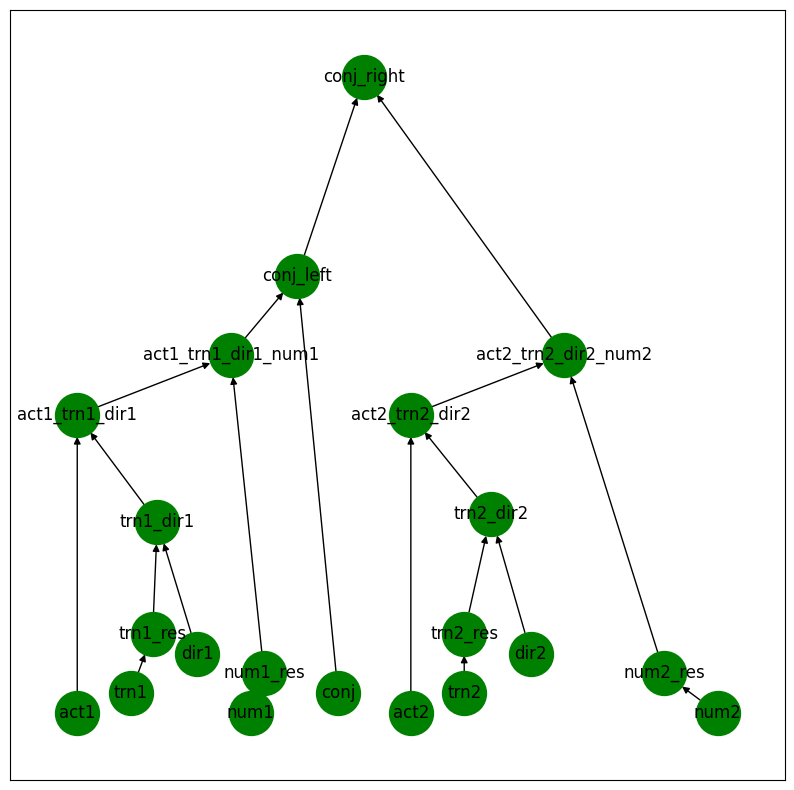

In [6]:
causal_model = CausalModel(variables, values, parents, functions, pos=pos)
causal_model.print_structure()

### Load dataset

In [82]:
# dataset splits
scan_simple = load_dataset('scan', 'simple', trust_remote_code=True)

# train and test splits
simple_train = scan_simple['train']
simple_test = scan_simple['test']

# cols
column_names = simple_train.column_names
input_column = column_names[0]
output_column = column_names[1]

## <sep> token? ##
# padded splits
def add_empty_token(x):
    command_str = x[input_column]
    command = command_str.split()
    padded_command = []
    index = 0
    c = 0
    while index < max_command_len:
        expected_cs = command_structure[index]
        if c < len(command) and command[c] in expected_cs:
            padded_command.append(command[c])
            c += 1
        else:
            padded_command.append(EMPTY)
        index += 1
    
    x[input_column] = ' '.join(padded_command)
    return x

simple_train_padded = simple_train.map(
    add_empty_token,
    batched=False,
    desc="Running tokenizer on dataset",
)
simple_test_padded = simple_test.map(
    add_empty_token,
    batched=False,
    desc="Running tokenizer on dataset",
)

### Intervention examples

#### Causal model with no intervention

base : {'commands': 'run opposite left <empty> after walk <empty> right <empty>', 'actions': 'I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN'}
No intervention:
 defaultdict(None, {'act1': 'run', 'act2': 'walk', 'conj': 'after', 'dir1': 'left', 'dir2': 'right', 'num1': '<empty>', 'num2': '<empty>', 'trn1': 'opposite', 'trn2': '<empty>', 'num1_res': '<empty>', 'num2_res': '<empty>', 'trn1_res': 'yy', 'trn2_res': '<empty>', 'trn1_dir1': 'I_TURN_LEFT I_TURN_LEFT <act>', 'trn2_dir2': 'I_TURN_RIGHT <act>', 'act1_trn1_dir1': 'I_TURN_LEFT I_TURN_LEFT I_RUN', 'act2_trn2_dir2': 'I_TURN_RIGHT I_WALK', 'act1_trn1_dir1_num1': 'I_TURN_LEFT I_TURN_LEFT I_RUN', 'act2_trn2_dir2_num2': 'I_TURN_RIGHT I_WALK', 'conj_left': '<port>I_TURN_LEFT I_TURN_LEFT I_RUN', 'conj_right': 'I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN'}) 



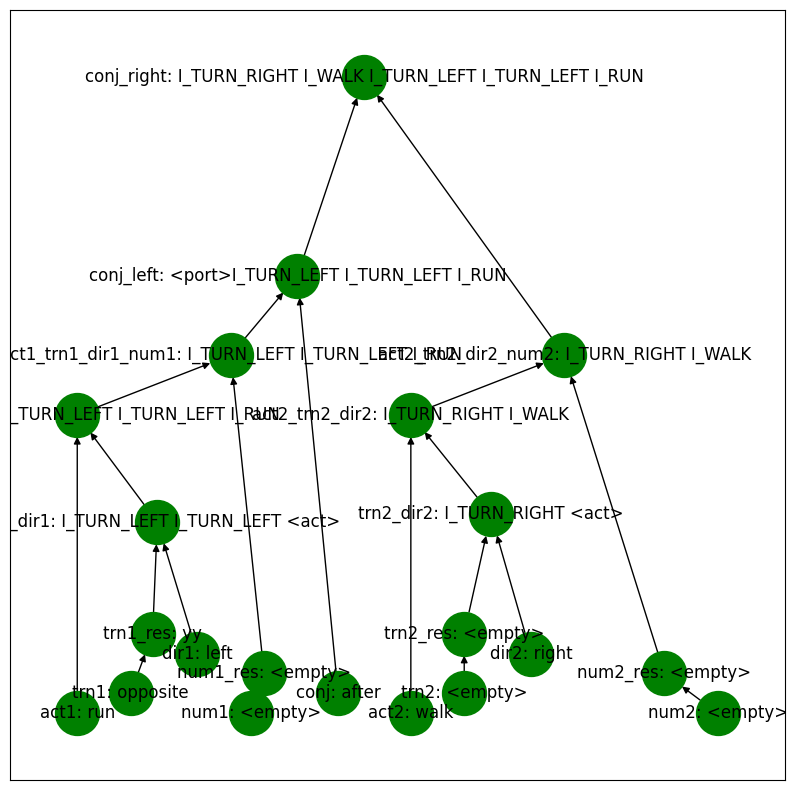

In [83]:
example = simple_train_padded[1]
print('base : {}'.format(example))

padded_command = example[input_column].split()
# assume leaves are correctly ordered from left to right
causal_model_inputs = {leaves[i]:padded_command[i] for i in range(max_command_len)}
base_setting = causal_model.run_forward(causal_model_inputs)
print("No intervention:\n", base_setting, "\n")
causal_model.print_setting(base_setting)

#### Causal model with an intervention

Intervention setting trn2_dir2 to left turn:



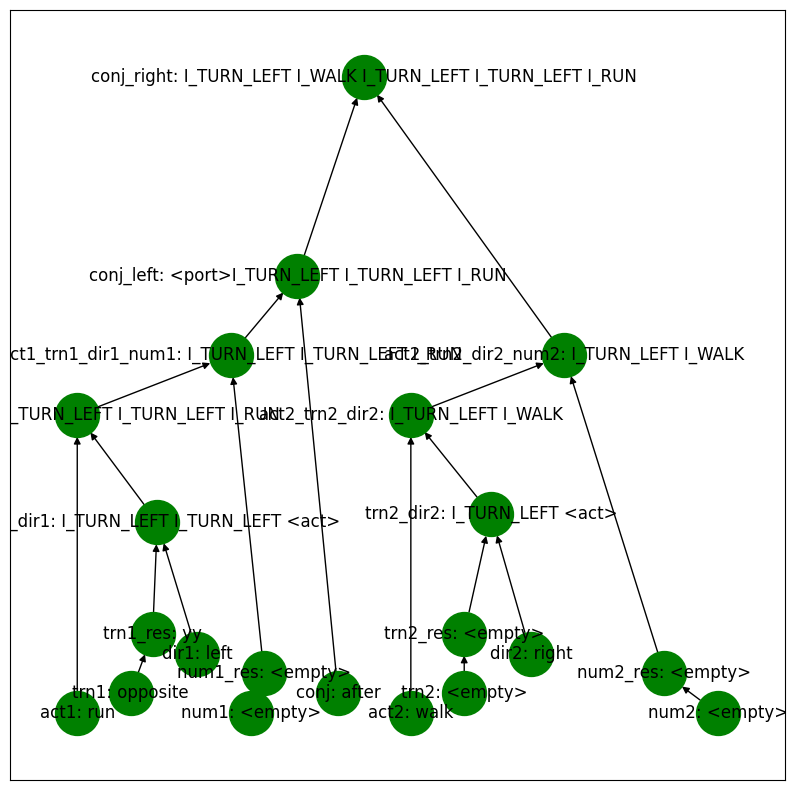

In [84]:
print("Intervention setting trn2_dir2 to left turn:\n",)
## how to do this intervention for gpt? ##
causal_model_inputs['trn2_dir2'] = directions['left'] + ' '+ACT

causal_model.print_setting(causal_model.run_forward(causal_model_inputs))

#### Interchange intervention

base example : {'commands': 'run opposite left <empty> after walk <empty> right <empty>', 'actions': 'I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN'}
source example : {'commands': 'walk <empty> <empty> <empty> after run around right twice', 'actions': 'I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_WALK'}


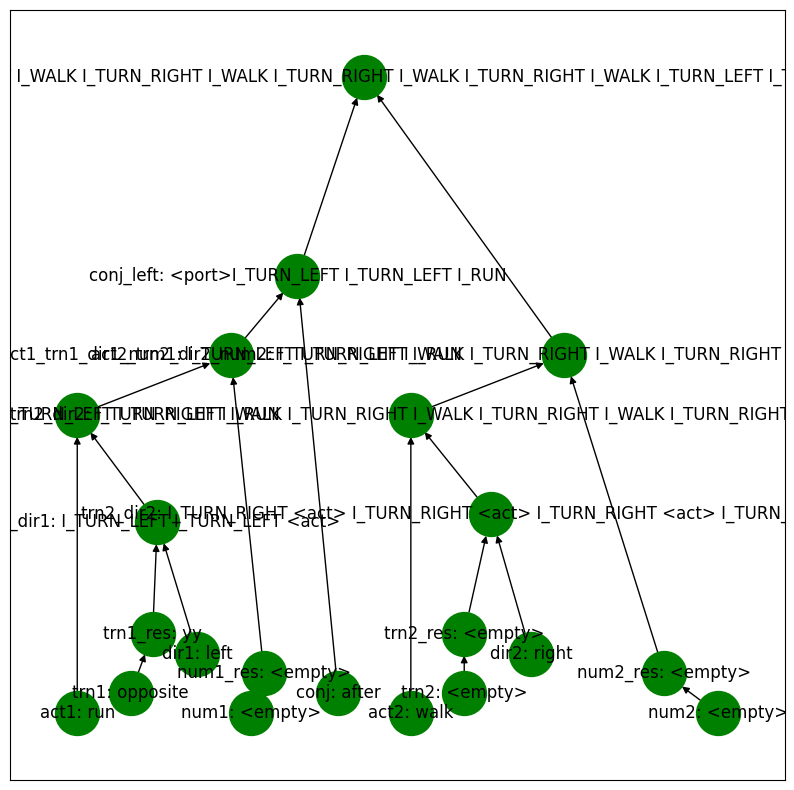

In [85]:
example = simple_train_padded[1]
print('base example : {}'.format(example))
padded_command = example[input_column].split()
base = {leaves[i]:padded_command[i] for i in range(max_command_len)}

source_example = simple_train_padded[2]
print('source example : {}'.format(source_example))
padded_command = source_example[input_column].split()
source = {leaves[i]:padded_command[i] for i in range(max_command_len)}
setting = causal_model.run_interchange(base, {"trn2_dir2": source})
causal_model.print_setting(setting)

In [86]:
print(base_setting['trn2_dir2'])
print(setting['trn2_dir2'])

I_TURN_RIGHT <act>
I_TURN_RIGHT <act> I_TURN_RIGHT <act> I_TURN_RIGHT <act> I_TURN_RIGHT <act>


### Intervention on conj_left

#### Build factual SCAN dataset

Make sure every sample has a conj. Sample each leaf and make sure it's a valid leaf value configuration for the input.

In [87]:
def validate_leaf_config(input):
    # condition1: conj cannot be empty
    if input['conj'] == EMPTY:
        return True
    # condition2 : actions cannot be empty
    if input['act1'] == EMPTY or input['act2'] == EMPTY:
        return True
    # condition3 : if direction is empty, turn has to be empty
    if input['dir1'] == EMPTY and input['trn1'] != EMPTY:
        return True
    if input['dir2'] == EMPTY and input['trn2'] != EMPTY:
        return True


def input_sampler():
    invalid_input = True
    while invalid_input:
        input = {}
        # randomly sample a value at each position
        for posn, val in command_structure.items():
            if isinstance(val, dict):
                command_type_keys = list(val.keys())
            elif isinstance(val, list):
                command_type_keys = val
            else:
                raise ValueError("Invalid command type. Check command type maps")
            r_key = random.choice(command_type_keys)
            # assuming leaves is a list with ordered values
            input[leaves[posn]] = r_key
        # check if sampled example is valid, else sample again
        invalid_input = validate_leaf_config(input)
    return input

#input_sampler()


In [88]:
# len(simple_train_padded) ~ 17k
n_examples = 20000
n_val_examples = 4000
n_test_examples = 4000

# input_ids: {'act1': 'jump', 'trn1': '<empty>', ...}, labels: defaultdict(None, {'act1': 'jump', 'act2': 'jump', ...}
train_examples = causal_model.generate_factual_dataset(
    size=n_examples,
    sampler=input_sampler,
    return_tensors=False
)
val_examples = causal_model.generate_factual_dataset(
    size=n_val_examples,
    sampler=input_sampler,
    return_tensors=False
)
test_examples = causal_model.generate_factual_dataset(
    size=n_test_examples,
    sampler=input_sampler,
    return_tensors=False
)

#### Train GPT2 on generated dataset (all samples with conj)

Hyperparameters and setup

In [89]:
gradient_accumulation_steps = 1
lr = 5e-5
train_steps = 100000
eval_steps = 5000
warmup_steps = 0
num_workers = os.cpu_count()
max_source_length = 512
weight_decay = 0.0
lr_scheduler_type = 'linear'

model_name_or_path = 'openai-community/gpt2'
output_dir = '/home/drdo/Caricatures/models/scan_simple_gen_gpt2'

# initialize accelerator
accelerator = Accelerator(
    mixed_precision=mixed_precision,
    gradient_accumulation_steps=gradient_accumulation_steps,
    log_with="tensorboard",
    project_dir=output_dir
)
# we need to initialize the trackers we use, and also store our configuration
track_config = {
    "lr": lr,
    "train_steps": train_steps,
    "seed": seed,
    "train_batch_size": batch_size,
}
accelerator.init_trackers('runs', track_config)

# tokenizer special tokens
special_tokens_dict = {
    "pad_token": "<pad>",
    "sep_token": "<sep>",
}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Load model and tokenizer

In [90]:
# tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path,)
tokenizer.add_special_tokens(special_tokens_dict)

# model
model = AutoModelForCausalLM.from_pretrained(model_name_or_path,)
# resize the embeddings when necessary to avoid index errors
embedding_size = model.get_input_embeddings().weight.shape[0]
if len(tokenizer) > embedding_size:
    model.resize_token_embeddings(len(tokenizer))

/home/drdo/anaconda3/envs/nlp/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Process generated dataset

In [91]:
# convert examples to Huggingface dataset
train_dataset = Dataset.from_list(train_examples)
val_dataset = Dataset.from_list(val_examples)

# process dataset for gpt input
def process_dataset(x):

    command_list = []
    leaf2comm = x['input_ids']
    # make sure leaves are odered correctly
    for leaf in leaves:
        command_list.append(leaf2comm[leaf])
    command = ' '.join(command_list)

    # only taking final output value
    action = x['labels']['conj_right']
    x['commands'] = command
    x['actions'] = action

    return x


with accelerator.main_process_first():
    train_dataset = train_dataset.map(
        process_dataset,
        batched=False,
        num_proc=1,
        remove_columns=train_dataset.column_names,
    )
    val_dataset = val_dataset.map(
        process_dataset,
        batched=False,
        num_proc=1,
        remove_columns=val_dataset.column_names,
    )

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [92]:
column_names = train_dataset.column_names
input_column = column_names[0]
output_column = column_names[1]

# preprocess dataset
def preprocess_function(examples):
    # commands, actions
    inputs = examples[input_column]
    targets = examples[output_column]

    # tokenize as single sequence separated by special token
    model_inputs = tokenizer(
        [i+tokenizer.sep_token for i in inputs],
        [t+tokenizer.eos_token for t in targets],
        padding='max_length', max_length=max_source_length
    )
    # labels same as inputs. labels shifted right in the model forward by default
    model_inputs['labels'] = model_inputs['input_ids'].copy()
    # set label padding to -100 
    model_inputs['labels'] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in model_inputs['labels']
    ]

    return model_inputs


with accelerator.main_process_first():
    train_dataset = train_dataset.map(
        preprocess_function,
        batched=True,
        num_proc=num_workers,
        remove_columns=column_names,
    )
    val_dataset = val_dataset.map(
        preprocess_function,
        batched=True,
        num_proc=num_workers,
        remove_columns=column_names,
    )

#print(tokenizer.decode(train_dataset[0]['input_ids'], skip_special_tokens=False))

Map (num_proc=32):   0%|          | 0/20000 [00:00<?, ? examples/s]

Map (num_proc=32):   0%|          | 0/4000 [00:00<?, ? examples/s]

Dataloaders, optimizer, scheduler

In [93]:
# data collator and loaders
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size
)
val_dataloader = DataLoader(
    val_dataset, collate_fn=default_data_collator, batch_size=batch_size
)

# prepare optimizer and schedule (linear warmup and decay)
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)

# scheduler
lr_scheduler = get_scheduler(
    name=lr_scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=warmup_steps * accelerator.num_processes,
    num_training_steps=train_steps * accelerator.num_processes,
)

Train

In [94]:
# prepare everything for accelerator
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)

global_step = 0  # tracks total steps
total_loss = 0  # total loss before each eval

accelerator.log({
    "train_batch_size": batch_size,
    "eval_batch_size": batch_size,
    "gpus": accelerator.state.num_processes
},
    step=global_step + 1,
)

In [95]:
# main progress bar
progress_bar = tqdm(range(global_step, train_steps), disable=not accelerator.is_main_process, position=0)
# val bar
val_bar = tqdm(range(len(val_dataloader)), position=1)

while True:

    model.train()

    for batch in train_dataloader:
        with accelerator.accumulate(model):
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.detach().float()
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            progress_bar.update(1)

        if (global_step + 1) % eval_steps == 0:
            model.eval()
            val_loss = 0
            
            for batch in val_dataloader:
                with torch.no_grad():
                    outputs = model(**batch)
                    val_loss += outputs.loss.item()

                val_bar.update(1)

            val_bar.refresh()
            val_bar.reset()

            accelerator.print('step : {}, val loss  : {}'.format(global_step + 1, val_loss/len(val_dataloader)))
            accelerator.log({
                "train_loss": total_loss / (eval_steps * accelerator.state.num_processes * batch_size),
                "val_loss": val_loss / len(val_dataloader)
            },
                step=global_step + 1,
            )

            # save the model, optimizer, lr_scheduler, and seed states by calling `save_state`
            # saved to folders named `checkpoint-{global_step}`
            # will contain files: "pytorch_model.bin", "optimizer.bin", "scheduler.bin", and "random_states.pkl"
            # if mixed precision was used, will also save a "scalar.bin" file
            c_dir = f"checkpoint-{global_step + 1}"
            if output_dir is not None:
                output_c_dir = os.path.join(output_dir, c_dir)
                accelerator.save_state(output_c_dir)
                # save config
                accelerator.wait_for_everyone()
                unwrapped_model = accelerator.unwrap_model(model)
                # model.config.save_pretrained(output_dir)
                unwrapped_model.config.save_pretrained(
                    output_c_dir, is_main_process=accelerator.is_main_process, save_function=accelerator.save
                )
                tokenizer.save_pretrained(output_c_dir)

            model.train()
            total_loss = 0

        global_step += 1

        if global_step >= train_steps:
            exit()


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Load trained GPT2 (on original SCAN dataset)

In [7]:
checkpoint = '/home/drdo/Caricatures/models/scan_distilgpt2/checkpoint-40000'
max_gen_length = 256

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = GPT2LMHeadModel.from_pretrained(checkpoint)
model.generation_config.max_length = max_gen_length

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
#generation_mode = GenerationMode.GREEDY_SEARCH

context = 'run <empty> right twice after walk <empty> right twice'
inputs = tokenizer(context+tokenizer.sep_token, return_tensors="pt")

output = model.generate(**inputs)[0]
output = tokenizer.decode(output, skip_special_tokens=False).replace(context+tokenizer.sep_token, '')
output = output.replace(tokenizer.eos_token, '')
print(output)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN


#### Eval on generated test data

In [16]:
# convert examples to Huggingface dataset
test_dataset = Dataset.from_list(test_examples)
# process dataset for gpt input
def process_dataset(x):

    command_list = []
    leaf2comm = x['input_ids']
    # make sure leaves are odered correctly
    for leaf in leaves:
        command_list.append(leaf2comm[leaf])
    command = ' '.join(command_list)

    # only taking final output value
    action = x['labels']['conj_right']
    x['commands'] = command
    x['actions'] = action

    return x


test_dataset = test_dataset.map(
    process_dataset,
    batched=False,
    num_proc=1,
    remove_columns=test_dataset.column_names,
)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [17]:
column_names = test_dataset.column_names
input_column = column_names[0]
output_column = column_names[1]

testset = test_dataset  #.select(range(100))

count = 0
model.to("cuda")
bar = tqdm(range(len(testset)))
for example in testset:
    command = example[input_column]
    label = example[output_column]
    inputs = tokenizer(command+tokenizer.sep_token, return_tensors="pt").to("cuda")
    output = model.generate(**inputs)[0].to("cpu")
    output = tokenizer.decode(output, skip_special_tokens=False).replace(command+tokenizer.sep_token, '')
    output = output.replace(tokenizer.eos_token, '')
    if output == label:
        count += 1
    bar.update(1)

print(count/len(testset))

  0%|          | 0/4000 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

0.931


In [18]:
print(count/len(testset))

0.931


#### Build counterfactual dataset

In [9]:
def validate_leaf_config_counterfactual(input):
    # condition1: conj cannot be empty
    if input['conj'] == EMPTY:
        return True
    # condition2 : actions cannot be empty
    if input['act1'] == EMPTY or input['act2'] == EMPTY:
        return True
    # condition3 : if direction is empty, turn has to be empty
    if input['dir1'] == EMPTY and input['trn1'] != EMPTY:
        return True
    if input['dir2'] == EMPTY and input['trn2'] != EMPTY:
        return True
    

def validate_by_model(x, causal_model, model, tokenizer, device):
    command = ' '.join(list(x.values()))
    label = causal_model.run_forward(x)['conj_right']
    inputs = tokenizer(command+tokenizer.sep_token, return_tensors="pt").to(device)
    output = model.generate(**inputs)[0].to("cpu")
    output = tokenizer.decode(output, skip_special_tokens=False).replace(command+tokenizer.sep_token, '')
    output = output.replace(tokenizer.eos_token, '')
    if output == label:
        return True
    else:
        return False


def generate_counterfactual_dataset_conj_left(
        causal_model,
        model,
        tokenizer, 
        device,
        size,
        intervention_id,
        batch_size,
        sampler=None,
        intervention_sampler=None,
        filter=None,
    ):
        # all non leaf non output variables
        maxlength = len(
            [
                var
                for var in causal_model.variables
                if var not in causal_model.inputs and var not in causal_model.outputs
            ]
        )
        if sampler is None:
            sampler = causal_model.sample_input
        if intervention_sampler is None:
            intervention_sampler = causal_model.sample_intervention

        examples = []
        bar = tqdm(range(size))
        while len(examples) < size:
            # dict with intermediate (non leaf) variable(s) and its (their) (intervened) value(s)
            # Ex: sample_intervention:
            # randomly select intermediate variables to intervene, then randomly select
            # possible values from their range
            intervention = intervention_sampler()
            if filter is None or filter(intervention):
                # same intervention for each batch
                for _ in range(batch_size):
                    example = dict()

                    # sample base input
                    invalid_input = True
                    # check if base is solved by given model
                    model_solvable = False
                    while invalid_input and not model_solvable:
                        base = sampler()
                        invalid_input = validate_leaf_config_counterfactual(base)
                        if not invalid_input:
                            model_solvable = validate_by_model(base, causal_model, model, tokenizer, device)

                    sources = []
                    # intervened_var : source input tensor
                    source_dic = {}
                    for var in causal_model.variables:
                        if var not in intervention:
                            continue
                        # sample input to match sampled intervention value for each intervened variable
                        # to get source input
                        # Ex: sample_input_tree_balanced:
                        # This will generate balanced samples since an output is first chosen at random
                        # and one of the possible input settings is derived recursively, top down.
                        # If output_var and out_var_value is given, this will generate an input setting
                        # to match the output variable.
                        # output_var can be an intermediate variable
                        invalid_input = True
                        # check if source is solved by given model
                        model_solvable = False
                        while invalid_input and not model_solvable:
                            source = sampler(output_var=var, output_var_value=intervention[var])
                            invalid_input = validate_leaf_config_counterfactual(source)
                            if not invalid_input:
                                model_solvable = validate_by_model(source, causal_model, model, tokenizer, device)

                        sources.append(source)
                        source_dic[var] = source

                    # pad sources to maxlength
                    for _ in range(maxlength - len(sources)):
                        sources.append({})

                    example['labels'] = causal_model.run_interchange(base, source_dic)
                    example['base_labels'] = causal_model.run_forward(base)
                    example['input_ids'] = base
                    example['source_input_ids'] = sources
                    example['intervention_id'] = [intervention_id(intervention)]

                    examples.append(example)

                    bar.update(1)
                    
        return examples
    

# you should be able to identify intervened variables from the id function
def conj_left_intervention_id(intervention):
    return 0


# need to make sure that intervention returns value (from all possible values),
# where conj is present
def conj_left_intervention_sampler():
    intervention = {}
    var = 'conj_left'
    port_condition = True
    while(port_condition):
        int_val = random.choice(causal_model.values[var])
        if PORT in int_val:
            intervention[var] = int_val
            port_condition = False
    return intervention

In [10]:
data_size = 4000

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
model.to(device)

counter_examples = generate_counterfactual_dataset_conj_left(
    causal_model,
    model,
    tokenizer,
    device,
    data_size,
    conj_left_intervention_id,
    batch_size,
    sampler=causal_model.sample_input_tree_balanced,
    intervention_sampler=conj_left_intervention_sampler,
)

  0%|          | 0/4000 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

This dataset has the following components:

* `input_ids`: base inputs
* `source_input_ids`: source, values will be empty dicts for non intervened vars
* `base_labels`: output labels with base for all non leaves
* `labels`: output labels with base and intervention from source for all non leaves
* `intervention_id`: same id since intervening on single variable

In [11]:
sample_id = 8

print(counter_examples[sample_id]["input_ids"])
# padded to maxlength
# maxlength = number of non leaf and non root nodes
print(counter_examples[sample_id]["source_input_ids"])
print(counter_examples[sample_id]["base_labels"])
print(counter_examples[sample_id]["labels"])
# you should be able to identify intervened variables from the id function
print(counter_examples[sample_id]["intervention_id"])

{'act1': 'run', 'trn1': '<empty>', 'dir1': 'right', 'num1': 'twice', 'conj': 'and', 'act2': 'turn', 'trn2': '<empty>', 'dir2': 'left', 'num2': 'twice'}
[{'act1': 'jump', 'trn1': 'around', 'dir1': 'left', 'num1': 'thrice', 'conj': 'and', 'act2': 'turn', 'dir2': 'left', 'num2': 'thrice', 'trn2': '<empty>'}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
defaultdict(None, {'act1': 'run', 'act2': 'turn', 'conj': 'and', 'dir1': 'right', 'dir2': 'left', 'num1': 'twice', 'num2': 'twice', 'trn1': '<empty>', 'trn2': '<empty>', 'num1_res': 'xx', 'num2_res': 'xx', 'trn1_res': '<empty>', 'trn2_res': '<empty>', 'trn1_dir1': 'I_TURN_RIGHT <act>', 'trn2_dir2': 'I_TURN_LEFT <act>', 'act1_trn1_dir1': 'I_TURN_RIGHT I_RUN', 'act2_trn2_dir2': 'I_TURN_LEFT <empty>', 'act1_trn1_dir1_num1': 'I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN', 'act2_trn2_dir2_num2': 'I_TURN_LEFT <empty> I_TURN_LEFT <empty>', 'conj_left': 'I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN<port>', 'conj_right': 'I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_L

In [12]:
print(counter_examples[0].keys())

print(counter_examples[sample_id]["base_labels"]['conj_right'].split()[0])
print(counter_examples[sample_id]["labels"]['conj_right'].split()[0])
print(counter_examples[sample_id]["input_ids"]['conj'])
print(counter_examples[sample_id]["source_input_ids"][0]['conj'])

dict_keys(['labels', 'base_labels', 'input_ids', 'source_input_ids', 'intervention_id'])
I_TURN_RIGHT
I_TURN_LEFT
and
and


In [40]:
#TODO : is counterfactual dataset balanced?

#### Intervention averaged across time steps

Intervention results with full generation. Loss for rotation matrices is averaged across all time steps.

##### Process counterfactual dataset

The model is perfect for this subset of examples. Therefore groundtruth labels = generated labels.

At t=k:

* `base_inputs`= `base_command` + `base_actions[0..k-1]`
* `source_inputs` = `source_command` + `source_actions[0..k-1]`
* `base_labels` = `base_actions[k]`
* `labels` = `label at k with base_inputs` + `intervention at site from source_inputs`

In [65]:
# convert examples to Huggingface dataset
counter_dataset = Dataset.from_list(counter_examples)

max_source_length = 20
# process dataset for gpt input
def process_dataset(x):

    # first convert to strings
    # then tokenize to tensors

    # base input_ids
    command_list = []
    leaf2comm = x['input_ids']
    # make sure leaves are odered correctly
    for leaf in leaves:
        command_list.append(leaf2comm[leaf])
    base = ' '.join(command_list)
    base = tokenizer(
        base+tokenizer.sep_token,
        padding='max_length',
        max_length=max_source_length
    )
    x['input_ids'] = base['input_ids']
    x['attention_mask'] = base['attention_mask']
    
    # source_input_ids
    command_list = []
    # only one intervention variable
    leaf2comm = x['source_input_ids'][0]
    # make sure leaves are odered correctly
    for leaf in leaves:
        command_list.append(leaf2comm[leaf])
    source = ' '.join(command_list)
    source = tokenizer(
        source+tokenizer.sep_token,
        padding='max_length',
        max_length=max_source_length
    )
    x['source_input_ids'] = source['input_ids']
    x['source_attention_mask'] = source['attention_mask']

    # pad labels on the fly later
    base_labels = x['base_labels']['conj_right']
    base_labels = tokenizer(base_labels)
    x['base_labels'] = base_labels['input_ids']

    # pad labels on the fly later
    labels = x['labels']['conj_right']
    labels = tokenizer(labels)
    x['labels'] = labels['input_ids']

    # intervention_id
    x['intervention_id'] = torch.tensor(x['intervention_id'])

    return x


counter_dataset_processed = counter_dataset.map(
    process_dataset,
    batched=False,
    num_proc=1,
)
counter_dataset_processed.set_format(type="torch")

print(counter_dataset_processed.column_names)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

['labels', 'base_labels', 'input_ids', 'source_input_ids', 'intervention_id', 'attention_mask', 'source_attention_mask']


##### DAS

In [14]:
config = IntervenableConfig(
    model_type=type(model),
    representations=[
        RepresentationConfig(
            0,  # layer
            "block_output",  # intervention component -> residual stream
            "pos",  # intervention unit is now aligned with tokens
            1,  # max number of unit
            subspace_partition=[[0, 128]], 
            # intervention_link_key=0,
        )
    ],
    intervention_types=RotatedSpaceIntervention,
)

In [15]:
intervenable = IntervenableModel(config, model, use_fast=True)
intervenable.set_device('cuda')
intervenable.disable_model_gradients()


In case multiple location tags are passed only the first one will be considered


In [90]:
ignore_index = -100
epochs = 3
gradient_accumulation_steps = 1
total_step = 0
target_total_step = len(counter_dataset_processed) * epochs
lr=0.001

t_total = int(len(counter_dataset_processed) * epochs)
optimizer_params = []
# single DAS intervention
for k, v in intervenable.interventions.items():
    optimizer_params += [{"params": v[0].rotate_layer.parameters()}]
    break
optimizer = torch.optim.Adam(optimizer_params, lr=lr)


# TODO: edit
def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        total_count += 1
        correct_count += eval_pred == eval_label
    accuracy = float(correct_count) / float(total_count)
    return {"accuracy": accuracy}


# TODO: check
def compute_loss(outputs, labels):
    CE = torch.nn.CrossEntropyLoss()
    return CE(outputs, labels)


def collate_function(batch):
    # input and source ids are already padded to max_source_len (20)
    # pad labels with ignore_index (-100)
    base_label_max_len = max([batch[i]['base_labels'].shape[0] for i in range(batch_size)])
    label_max_len = max([batch[i]['labels'].shape[0] for i in range(batch_size)])

    for b in range(batch_size):
        base_label = batch[b]['base_labels']
        label = batch[b]['labels']
        base_label = F.pad(base_label, (0, base_label_max_len-base_label.shape[0]), value=ignore_index)
        label = F.pad(label, (0, label_max_len-label.shape[0]), value=ignore_index)
        batch[b]['base_labels'] = base_label
        batch[b]['labels'] = label

    # turn batch from list of dicts to dict of lists
    # https://stackoverflow.com/questions/5558418/list-of-dicts-to-from-dict-of-lists
    batch = {k: torch.stack([dic[k] for dic in batch]) for k in batch[0]}

    return batch


def batched_random_sampler(data):
    batch_indices = [_ for _ in range(int(len(data) / batch_size))]
    random.shuffle(batch_indices)
    for b_i in batch_indices:
        for i in range(b_i * batch_size, (b_i + 1) * batch_size):
            yield i

In [91]:
intervenable.model.train()  # train enables drop-off but no grads
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")

total_step = 0
for epoch in train_iterator:
    epoch_iterator = tqdm(
        DataLoader(
            counter_dataset_processed,
            collate_fn=collate_function,
            sampler=batched_random_sampler(counter_dataset_processed),
            batch_size=batch_size,
            drop_last=True
        ),
        desc=f"Epoch: {epoch}",
        position=0,
        leave=True
    )
    for batch in epoch_iterator:
        # base
        inputs = {
            "inputs_ids": batch["input_ids"],
            "attention_mask": batch["attention_mask"]
        }
        # list of source inputs
        sources = [
            {
                "inputs_ids": batch["source_input_ids"],
                "attention_mask": batch["source_attention_mask"]
            }
        ]
        # TODO : 
        _, counterfactual_outputs = intervenable(
            inputs,
            sources,
            {"sources->base": ([[[MAX_LENGTH - 2]] * batch_size], [[[MAX_LENGTH - 2]] * batch_size])},
            subspaces=[[[0]] * batch_size],
        )

        eval_metrics = compute_metrics(
            counterfactual_outputs.logits.argmax(-1), batch["label"].to(intervenable.get_device())
        )

        # loss and backprop
        loss = compute_loss(
            counterfactual_outputs.logits, batch["label"].to(intervenable.get_device())
        )

        epoch_iterator.set_postfix({"loss": loss.item(), "acc": eval_metrics["accuracy"]})

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            optimizer.step()
            intervenable.set_zero_grad()
        total_step += 1

intervention trainable parameters:  589824


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0: 0it [00:00, ?it/s]

<class 'dict'>


RuntimeError: No active exception to reraise